## Imports

In [1]:
import numpy as np
from tqdm import trange

from kuramoto import Kuramoto
from kuramoto.db_metrics import *

from NNetwork import NNetwork as nn
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import svm
from sklearn import metrics, model_selection
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA ### Use truncated SVD / online PCA later for better computational efficiency

import warnings
warnings.filterwarnings("ignore")

## Plotting Functions

#### 1. Display Graphs

In [2]:
def display_graphs(title,
                     save_path,
                     grid_shape=[2,3],
                     fig_size=[10,10],
                     data = None, # [X, embs]
                     show_importance=False):

        # columns of X = vectorized k x k adjacency matrices
        # corresponding list in embs = sequence of nodes (may overalp)
        X, embs = data
        print('X.shape', X.shape)

        rows = grid_shape[0]
        cols = grid_shape[1]

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        # make outer gridspec

        idx = np.arange(X.shape[1])
        outer_grid = gridspec.GridSpec(nrows=rows, ncols=cols, wspace=0.02, hspace=0.02)

        # make nested gridspecs
        for i in range(rows * cols):
            a = i // cols
            b = i % rows

            Ndict_wspace = 0.05
            Ndict_hspace = 0.05

            # display graphs
            inner_grid = outer_grid[i].subgridspec(1, 1, wspace=Ndict_wspace, hspace=Ndict_hspace)

            # get rid of duplicate nodes
            A = X[:,idx[i]]
            A = X[:,idx[i]].reshape(int(np.sqrt(X.shape[0])), -1)
            H = nn.NNetwork()
            H.read_adj(A, embs[idx[i]])
            A_sub = H.get_adjacency_matrix()

            # read in as a nx graph for plotting
            G1 = nx.from_numpy_matrix(A_sub)
            ax = fig.add_subplot(inner_grid[0, 0])
            pos = nx.spring_layout(G1)
            edges = G1.edges()
            weights = [1*G1[u][v]['weight'] for u,v in edges]
            nx.draw(G1, with_labels=False, node_size=20, ax=ax, width=weights, label='Graph')

            ax.set_xticks([])
            ax.set_yticks([])

        plt.suptitle(title, fontsize=15)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

#### 2. Display Dictionaries

In [3]:
def display_dictionary(W, save_name=None, score=None, grid_shape=None, figsize=[10,10]):
    k = int(np.sqrt(W.shape[0]))
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=figsize
    if (score is None) and (grid_shape is not None):
        figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
        figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

#### 3. Display both Graphs and Dictionaries

In [4]:
def display_dict_and_graph(title,
                           W, 
                           singular_values, 
                           save_path,
                           grid_shape=None,
                           fig_size=[10,10],
                           show_importance=False,
                           only_show_matrices=True):
        
        n_components = W.shape[1]
        k = int(np.sqrt(W.shape[0]))

        rows = np.round(np.sqrt(n_components))
        rows = rows.astype(int)
        if grid_shape is not None:
            rows = grid_shape[0]
            cols = grid_shape[1]
        else:
            if rows ** 2 == n_components:
                cols = rows
            else:
                cols = rows + 1

        if show_importance:
            # importance = np.sum(self.code, axis=1) / sum(sum(self.code))
            idx = np.argsort(singular_values)
            idx = np.flip(idx)
        else:
            idx = np.arange(W.shape[1])

        Ndict_wspace = 0.05
        Ndict_hspace = 0.05

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        ncols = 2 
        if only_show_matrices:
            ncols = 1
        outer_grid = gridspec.GridSpec(nrows=1, ncols=ncols, wspace=0.02, hspace=0.02)
        for t in np.arange(2):
            # make nested gridspecs

            if t == 0:
                ### Make gridspec
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
                    # ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                    # ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
                    ax.set_xticks([])
                    ax.set_yticks([])
            if (t == 1) and not only_show_matrices:
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols

                    G1 = nx.from_numpy_matrix(W[:,idx[i]].reshape(int(np.sqrt(W.shape[0])),-1))
                    ax = fig.add_subplot(inner_grid[a, b])
                    pos = nx.spring_layout(G1)
                    edges = G1.edges()
                    weights = [2*G1[u][v]['weight'] for u,v in edges]
                    nx.draw(G1, with_labels=False, node_size=10, ax=ax, width=weights, label='Graph')
                    if show_importance:
                        ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                        ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches

                    ax.set_xticks([])
                    ax.set_yticks([])

        if title is not None:
            plt.suptitle(title, fontsize=25)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

## NMF Functions

In [5]:
def coding(X, W, H0, 
          r=None, 
          a1=0, #L1 regularizer
          a2=0, #L2 regularizer
          sub_iter=[5], 
          stopping_grad_ratio=0.0001, 
          nonnegativity=True,
          subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    grad = W.T @ (W @ H0 - X)
    while (i < np.random.choice(sub_iter)):
        step_size = (1 / (((i + 1) ** (1)) * (np.trace(A) + 1)))
        H1 -= step_size * grad 
        if nonnegativity:
            H1 = np.maximum(H1, 0)  # nonnegativity constraint
        i = i + 1
    return H1


def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            #H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            #W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            H = coding(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            W /= np.linalg.norm(W)
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

## Network Sampling - Caltech

In [102]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = '../Subgraph_sampling/test_Agam/'
k = 30

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


num of subgraphs induced on k-paths: 100
X.shape (900, 100)


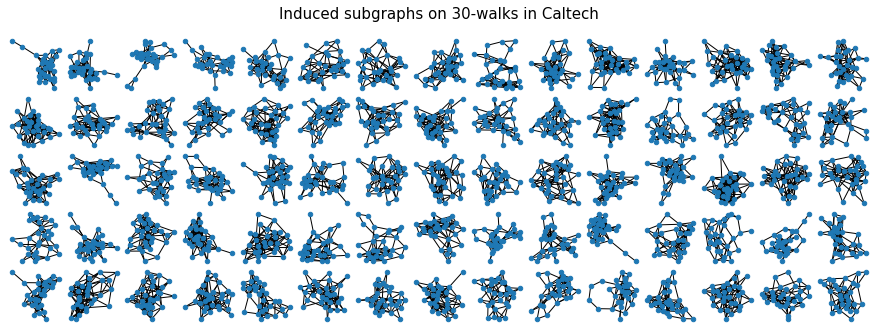

In [103]:
X, embs = G.get_patches(k=k, sample_size=100, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [104]:
def generate_nxg(get_patches_X):
    
    graph_list = []
    for i in range(X.shape[1]):
        adj_mat = X.T[i].reshape(30,30)
        G = nx.from_numpy_matrix(adj_mat)
        graph_list.append(G)
    
    return graph_list

In [105]:
graph_list = generate_nxg(X)

In [106]:
def predict_concentration(arr):
    v1 = []
    for i in range(len(arr) - 1) :
        diff = arr[i + 1] - arr[i]
        v1.append(diff)
    extra_diff = (2*np.pi - arr[len(arr) - 1]) + arr[0]
    v1.append(extra_diff)
            
    v1 = np.array(v1)
            
    width = np.abs(2*np.pi - v1.max())
    threshold = np.pi
            
    if width < threshold: 
        return True
    else: 
        return False

In [108]:
nodes = int(np.sqrt(X.shape[0]))
r = 125
df = pd.DataFrame()

for G in graph_list:
    
    headers = []
    for i in range(1, nodes+1):
        for j in range(1, r+1):
            headers.append(f's{i}_{j}')
        
    df1 = pd.DataFrame(columns=['# Edges', '# Nodes', 'Min Degree', 'Max Degree', 'Diameter', 'Synchronized'])
    temp = pd.DataFrame()
        
    if nx.is_connected(G):
        edges = G.number_of_edges()
        nodes = G.number_of_nodes()

        degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
        dmax = max(degree_sequence)
        dmin = min(degree_sequence)

        diam = nx.diameter(G)

        # Applying Kuramoto
        adj_mat = nx.to_numpy_array(G)
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, base_iter=r, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = predict_concentration(arr)
            
        df1.at[len(df1.index)] = [edges, nodes, dmin, dmax, diam, conc]

        df2 = pd.DataFrame(sim[:,:r].flatten(order='C')).T
        df2.columns = headers
            
        temp = pd.concat([df2, df1], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,s1_1,s1_2,s1_3,s1_4,s1_5,s1_6,s1_7,s1_8,s1_9,s1_10,...,s30_122,s30_123,s30_124,s30_125,# Edges,# Nodes,Min Degree,Max Degree,Diameter,Synchronized
0,2.464476,2.479536,2.494655,2.509831,2.525066,2.540359,2.555710,2.571118,2.586583,2.602104,...,5.462578,5.456548,5.450530,5.444522,102,30,1,12,5,True
1,1.934433,1.916219,1.897778,1.879108,1.860202,1.841058,1.821670,1.802036,1.782150,1.762009,...,4.161550,4.176805,4.192089,4.207406,94,30,1,12,5,True
2,6.245141,6.236874,6.228567,6.220219,6.211828,6.203396,6.194920,6.186401,6.177838,6.169230,...,3.253210,3.265703,3.278217,3.290753,82,30,2,12,5,True
3,0.713960,0.704211,0.694269,0.684138,0.673823,0.663328,0.652660,0.641825,0.630827,0.619675,...,2.789662,2.801409,2.813152,2.824888,79,30,1,12,5,True
4,4.751602,4.747204,4.742778,4.738327,4.733856,4.729368,4.724868,4.720359,4.715844,4.711329,...,3.314550,3.318491,3.322466,3.326474,86,30,1,15,5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.526831,5.523359,5.519868,5.516358,5.512829,5.509280,5.505710,5.502118,5.498504,5.494868,...,3.226536,3.224398,3.222272,3.220158,88,30,2,13,5,True
96,2.921423,2.921165,2.920941,2.920752,2.920597,2.920477,2.920393,2.920343,2.920329,2.920350,...,5.616799,5.615075,5.613309,5.611501,100,30,2,13,4,True
97,4.611452,4.612712,4.613982,4.615263,4.616555,4.617858,4.619172,4.620497,4.621835,4.623183,...,5.498739,5.503495,5.508212,5.512891,105,30,2,15,4,True
98,0.113833,0.106667,0.099415,0.092072,0.084637,0.077107,0.069479,0.061750,0.053919,0.045983,...,1.870736,1.863052,1.855399,1.847776,103,30,2,14,4,True


In [111]:
X, y = df.iloc[:, :-1], df.iloc[:, [-1]]
y = y.astype('int')

In [112]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

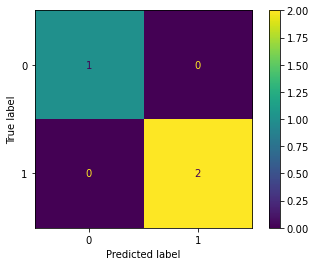

Precision: 1.000
Recall: 1.000
F1: 1.000
Accuracy: 1.000


In [116]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

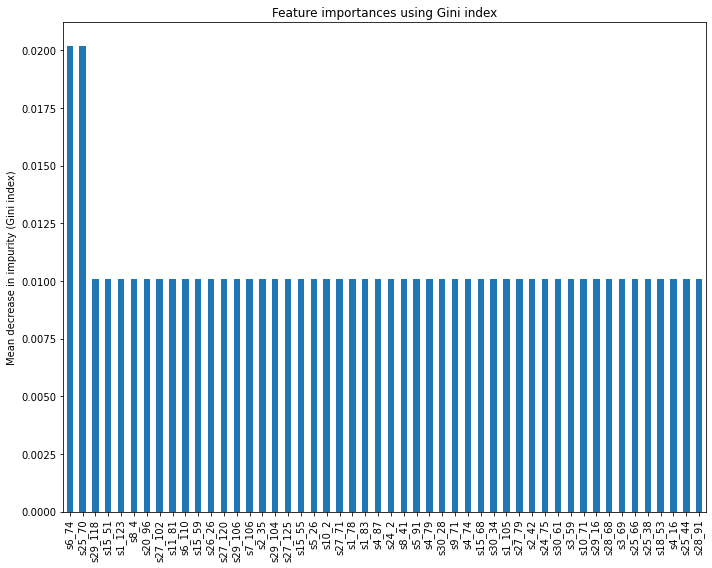

In [117]:
plot_gini_index(clf, X_train)

In [120]:
X_resampled

,s1_1,s1_2,s1_3,s1_4,s1_5,s1_6,s1_7,s1_8,s1_9,s1_10,...,s30_121,s30_122,s30_123,s30_124,s30_125,# Edges,# Nodes,Min Degree,Max Degree,Diameter
0,6.190977,6.203833,6.216590,6.229244,6.241794,6.254237,6.266571,6.278794,0.007719,0.019716,...,2.766748,2.771044,2.775332,2.779612,2.783883,86,30,2,17,4
1,4.477659,4.480242,4.482892,4.485608,4.488388,4.491229,4.494130,4.497089,4.500104,4.503174,...,4.348705,4.322161,4.295889,4.269888,4.244159,89,30,2,11,5
2,2.875319,2.872474,2.869669,2.866904,2.864180,2.861496,2.858852,2.856250,2.853688,2.851167,...,4.713089,4.713461,4.713810,4.714136,4.714441,104,30,1,15,4
3,2.583074,2.581222,2.579383,2.577558,2.575748,2.573955,2.572178,2.570420,2.568681,2.566962,...,3.930437,3.931463,3.932427,3.933330,3.934173,79,30,2,15,6
4,3.799288,3.804953,3.810555,3.816096,3.821574,3.826989,3.832342,3.837633,3.842861,3.848027,...,2.888379,2.894697,2.900989,2.907256,2.913499,74,30,2,12,4
5,6.245141,6.236874,6.228567,6.220219,6.211828,6.203396,6.194920,6.186401,6.177838,6.169230,...,3.240738,3.253210,3.265703,3.278217,3.290753,82,30,2,12,5
6,0.675339,0.661709,0.648039,0.634330,0.620582,0.606795,0.592969,0.579105,0.565203,0.551264,...,1.841898,1.839675,1.837473,1.835294,1.833136,114,30,1,15,6
7,4.660595,4.675765,4.690929,4.706086,4.721234,4.736370,4.751495,4.766605,4.781700,4.796777,...,1.885700,1.899788,1.913872,1.927954,1.942034,91,30,2,11,4
8,2.424588,2.420613,2.416612,2.412584,2.408530,2.404448,2.400339,2.396201,2.392033,2.387837,...,1.408272,1.407126,1.406018,1.404947,1.403913,99,30,2,16,4
9,1.607991,1.602252,1.596490,1.590703,1.584891,1.579054,1.573192,1.567303,1.561388,1.555446,...,3.364701,3.356384,3.348023,3.339621,3.331179,121,30,3,16,3


In [121]:
y_resampled

,Synchronized
0,0
1,0
2,0
3,0
4,0
5,1
6,1
7,1
8,1
9,1


In [151]:
X_true = X_resampled.iloc[5:10, :3600].values
X_false = X_resampled.iloc[:5, :3600].values

In [152]:
W_true, H_true = ALS(X = X_true, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 100, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 1356.82it/s]

iteration 0, reconstruction error 159242.331656
iteration 10, reconstruction error 8709.866913
iteration 20, reconstruction error 2632.427837
iteration 30, reconstruction error 1260.011566
iteration 40, reconstruction error 675.402018
iteration 50, reconstruction error 393.293014
iteration 60, reconstruction error 245.941080
iteration 70, reconstruction error 166.018342
iteration 80, reconstruction error 118.942426
iteration 90, reconstruction error 88.823343


ValueError: cannot reshape array of size 5 into shape (2,2)

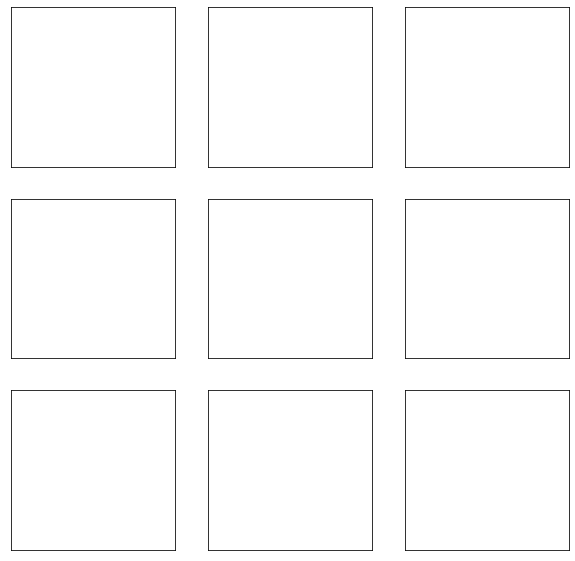

In [146]:
display_dictionary(W_true, figsize=[10,10])